banner IA (11).png

In [ ]:
#@title Importar librerías { display-mode: "form" }
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [ ]:
#@title Crear funciones { display-mode: "form" }

#Creates a dataset with bing searches with a structure
#  Dataset
#    Class1
#      Sample1
#      Sample2
#      ...
#      Samplen
#    ...
#    Classn
def create_dataset_from_bing(num_samples,search_terms,subscription_key,search_url,license='all',imageType='all',filetype='.jpg',path='/content'):
  #To obtain the information you need https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/
  for term in search_terms:
    os.chdir(path)
    try:
      os.mkdir(term)
    except OSError:
      continue
    if (path=='/'):
      os.chdir(path+term+'/')
    else:
      os.chdir(path+'/'+term)
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"q": term, "license": license, "imageType": imageType, "filetype": filetype}

    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"][:num_samples]]

    i=0
    for url in thumbnail_urls:
      #print(url)
      r = requests.get(thumbnail_urls[i])
      i = str(i)
      img_name = term+i+filetype
      with open(img_name, "wb") as f:
        f.write(r.content)
      i = int(i)
      i=i+1

#Makes a list with all the classes in the dataset
def create_class_list(path_classes):
  classes_names = os.listdir(path_classes)
  classes_names.sort()
  return classes_names

#Filters the corrupt data images
def img_filter(classes_names):
  num_skipped = 0
  for folder_name in (classes_names):
    folder_path = os.path.join(path_classes, folder_name)
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      try:
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)
  print("Deleted %d images" % num_skipped)

#Makes a list of all the samples with its path
def dir_list(classes_names):
  list_dirs = []
  for i, name_class in enumerate(classes_names):
    list_dirs = list_dirs +[name_class+ "/"+ s for s in (os.listdir(path_classes + '/' + classes_names[i]))]
  list_dirs = np.array(list_dirs)
  return list_dirs

#Makes a list of all the samples with its corresponding label
def dir_list_class(classes_names,list_dirs):
  s=[]
  s_code=[]
  i = 0
  for name in classes_names:
    patron = name+'/'
    for img in list_dirs:
      if (img.startswith(patron)):
        s.append(name)
        s_code.append(i)
    i = i + 1
  files_class = pd.DataFrame(list_dirs,columns=['files'])
  files_class['class_name'] = pd.Series(s)
  files_class['class'] = pd.Series(s_code)
  return files_class

#Shows some data about the samples distribution (class balance)
def class_balance(classes_names,files_class):
  total = []
  print('summatory for class:\n')
  for name in classes_names:
    count = len(files_class[files_class['class_name']==name])
    print(name,'->',count)
    total.append(count)
  total = np.array(total)
  print('\nmean:',total.mean())
  print('standard deviation:',total.std())
  print('min value:',total.min())
  print('max value:',total.max())

#Slipts the data paths in two groups (train-test)
def dirs_split(files_class,train_percent):
  files_class = files_class.reindex(np.random.permutation(files_class.index))
  n = int(len(files_class)*train_percent)
  X = files_class['files']
  y = files_class['class']
  files_train = X.iloc[:n]
  classes_train = y.iloc[:n]
  files_test = X.iloc[n:]
  classes_test = y.iloc[n:]
  return files_train,classes_train,files_test,classes_test

#Load and preprocess the images in the  and classes paths
def make_data(files,classes):
  x = []
  y = []
  for image, clase in zip(files, classes):
    image = path_classes+'/'+image
    im = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    ima = tf.keras.preprocessing.image.img_to_array(im)
    x.append(ima)
    y.append(clase)
  x = np.array(x)
  y = np.array(y)
  return x,y

#Data normalization
def data_norm(x_train,y_train,x_test,y_test):
  x_train = x_train.reshape([-1, 224, 224, 3])
  x_test = x_test.reshape([-1, 224, 224, 3])

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  y_test = tf.keras.utils.to_categorical(y_test)
  y_train = tf.keras.utils.to_categorical(y_train) 

  x_train /= 255
  x_test /= 255
  print('x_train shape:', x_train.shape)
  print('Number of images in x_train', x_train.shape[0], "y_train:", y_train.shape)
  print('Number of images in x_test', x_test.shape[0], "y_test: ", y_test.shape)

  return x_train,y_train,x_test,y_test

## Descargar el dataset

In [ ]:
#Mount at content/data or reate the directory if doesnt exists
try:
    os.mkdir('/content/data')
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
os.chdir('/content/data')
print(os.getcwd())

Successfully created the directory
/content/data


Descargar de git

In [ ]:
!git clone https://github.com/Akshay090/pokemon-image-dataset

Cloning into 'pokemon-image-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 637 (delta 1), reused 1 (delta 0), pack-reused 628
Receiving objects: 100% (637/637), 104.30 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Descargar de kaggle

In [ ]:
#os.environ['KAGGLE_USERNAME'] = "juliantolosa" # username from the json file
#os.environ['KAGGLE_KEY'] = "b5bf51d3af585fd839ec22d8e52c2137" # key from the json file
#!kaggle datasets download -d thedagger/pokemon-generation-one/download

 99% 329M/331M [00:18<00:00, 13.6MB/s]
100% 331M/331M [00:18<00:00, 19.0MB/s]


Crear dataset con búsquedas de Bing


In [ ]:
#create_dataset_from_bing(5,["Superman","Batman"],subscription_key = "73b3a067c0b442c680b1a84cbcfac110",search_url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search",filetype='.png')

In [ ]:
!ls

pokemon-image-dataset


Si el dataset es descargado como un archivo comprimido

In [ ]:
#!unzip pokemon-5-dataset.zip

## Crear una lista con todas las clases (nombres de los pokemon)

In [ ]:
os.chdir('/content/data')

path_classes = 'pokemon-image-dataset/'
!ls ../data/pokemon-image-dataset/

bulbasaur  charmander  pikachu	README.md  squirtle


### Borrar directorios inútiles y problemáticos

El archivo ../data/pokemon-image-dataset/README.md no es útil, al igual que el directorio oculto ../data/pokemon-image-dataset/.git creado por git, por lo que ambos se eliminan

In [ ]:
!rm ../data/pokemon-image-dataset/README.md
!rm -r ../data/pokemon-image-dataset/.git

### Crea la lista con el directorio limpio de cosas innecesarias

In [ ]:
classes_names = create_class_list(path_classes)
num_class = len(classes_names)

print('List\n',classes_names)
print('\nNumber of classes\n',num_class)

List
 ['bulbasaur', 'charmander', 'pikachu', 'squirtle']

Number of classes
 4


## Filtrar imágenes corruptas

In [ ]:
img_filter(classes_names)

Deleted 242 images


## Crear dataset con las direcciones de las imágenes y su respectiva etiqueta

### Lista de todas las direcciones de las imagenes

In [ ]:
list_dirs = dir_list(classes_names) 
print("First element:",list_dirs[0], "  |  shape:",list_dirs.shape)
print('Total elements:', len(list_dirs))

First element: bulbasaur/00000115.jpg   |  shape: (363,)
Total elements: 363


### Dataset con la etiqueta para cada imagen

In [ ]:
files_class = dir_list_class(classes_names,list_dirs)
files_class

files class_name  class
0    bulbasaur/00000115.jpg  bulbasaur      0
1    bulbasaur/00000206.jpg  bulbasaur      0
2    bulbasaur/00000105.jpg  bulbasaur      0
3    bulbasaur/00000124.jpg  bulbasaur      0
4    bulbasaur/00000054.jpg  bulbasaur      0
..                      ...        ...    ...
358   squirtle/00000004.jpg   squirtle      3
359   squirtle/00000174.jpg   squirtle      3
360   squirtle/00000009.jpg   squirtle      3
361   squirtle/00000045.jpg   squirtle      3
362   squirtle/00000012.jpg   squirtle      3

[363 rows x 3 columns]

## Análisis de los datos

### Balance de las clases

In [ ]:
class_balance(classes_names,files_class)

summatory for class:

bulbasaur -> 91
charmander -> 77
pikachu -> 132
squirtle -> 63

mean: 90.75
standard deviation: 25.791229129298976
min value: 63
max value: 132


Se observa un desbalance considerable ¿Podría usarse una función de aumento para tratar de mejorar esto un poco?

## Crear el dataset

### Separación de train y test (70% - 30%)

In [ ]:
train_percent = 0.7

files_train,classes_train,files_test,classes_test = dirs_split(files_class,train_percent)

#### Ver los datos

In [ ]:
files_train

165    charmander/00000150.jpg
218       pikachu/00000204.jpg
149    charmander/00000077.jpg
350      squirtle/00000090.jpg
190       pikachu/00000101.jpg
                ...           
124    charmander/00000170.jpg
4       bulbasaur/00000054.jpg
284       pikachu/00000017.jpg
254       pikachu/00000030.jpg
120    charmander/00000194.jpg
Name: files, Length: 254, dtype: object

In [ ]:
classes_train

165    1
218    2
149    1
350    3
190    2
      ..
124    1
4      0
284    2
254    2
120    1
Name: class, Length: 254, dtype: int64

In [ ]:
files_test

358      squirtle/00000004.jpg
355      squirtle/00000161.jpg
89      bulbasaur/00000027.jpg
52      bulbasaur/00000116.jpg
55      bulbasaur/00000143.jpg
                ...           
153    charmander/00000050.jpg
206       pikachu/00000001.jpg
199       pikachu/00000024.jpg
357      squirtle/00000141.jpg
59     bulbasaur/00000169.jpeg
Name: files, Length: 109, dtype: object

In [ ]:
classes_test

358    3
355    3
89     0
52     0
55     0
      ..
153    1
206    2
199    2
357    3
59     0
Name: class, Length: 109, dtype: int64

### Cargar las imagenes

#### Train

In [ ]:
x_train,y_train = make_data(files_train,classes_train)

print(x_train.shape)
print(y_train.shape)

(254, 224, 224, 3)
(254,)


#### Test

In [ ]:
x_test,y_test = make_data(files_test,classes_test)

print(x_test.shape)
print(y_test.shape)

(109, 224, 224, 3)
(109,)


In [ ]:
x_train,y_train,x_test,y_test = data_norm(x_train,y_train,x_test,y_test)

x_train shape: (254, 224, 224, 3)
Number of images in x_train 254 y_train: (254, 4)
Number of images in x_test 109 y_test:  (109, 4)


## Modelar la CNN

In [ ]:
model_CNN = tf.keras.models.Sequential()
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())

model_CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())

model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dense(128, kernel_initializer='lecun_uniform', bias_initializer='lecun_uniform',  activation='relu'))

model_CNN.add(tf.keras.layers.Dense(num_class, activation='softmax'))

model_CNN.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      2

### Entrenar la red

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model_CNN.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_CNN.fit(x_train, y_train, epochs=50,verbose=1, batch_size=32,validation_data=(x_test, y_test))

Epoch 1/50
8/8 [==============================] - 9s 1s/step - loss: 412.0156 - accuracy: 0.5787 - val_loss: 4554.3984 - val_accuracy: 0.4954
Epoch 2/50
8/8 [==============================] - 5s 606ms/step - loss: 212.1821 - accuracy: 0.7992 - val_loss: 18033.7617 - val_accuracy: 0.2110
Epoch 3/50
8/8 [==============================] - 5s 602ms/step - loss: 110.6617 - accuracy: 0.9094 - val_loss: 10735.5410 - val_accuracy: 0.4128
Epoch 4/50
8/8 [==============================] - 5s 605ms/step - loss: 118.1943 - accuracy: 0.9252 - val_loss: 15871.8906 - val_accuracy: 0.4312
Epoch 5/50
8/8 [==============================] - 5s 606ms/step - loss: 26.3003 - accuracy: 0.9213 - val_loss: 44716.3867 - val_accuracy: 0.3578
Epoch 6/50
8/8 [==============================] - 5s 607ms/step - loss: 80.9579 - accuracy: 0.9055 - val_loss: 7315.9727 - val_accuracy: 0.5596
Epoch 7/50
8/8 [==============================] - 5s 603ms/step - loss: 32.4186 - accuracy: 0.9685 - val_loss: 5082.1118 - val_accu

In [ ]:
test_loss,test_acc = model_CNN.evaluate(x_test,y_test)

print('\nTest accuracy:',test_acc)
print('Test loss:',test_loss)

4/4 [==============================] - 0s 92ms/step - loss: 1151.0770 - accuracy: 0.7064

Test accuracy: 0.7064220309257507
Test loss: 1151.0770263671875


In [ ]:
#@title plot

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
model_A =  tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
embedding_layer_1 = tf.keras.layers.Dense(256, kernel_initializer='normal', activation='relu')
embedding_layer_2 = tf.keras.layers.Dense(128, kernel_initializer='normal', activation='relu')
embedding_layer_3 = tf.keras.layers.Dense(num_class, activation='softmax')

flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [ ]:
model_B_on_A = tf.keras.Sequential([
  model_A,
  global_average_layer,
  embedding_layer_1,
  embedding_layer_2,
  embedding_layer_3
])

In [ ]:
model_B_on_A.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 2,619,332
Trainable params: 361,348
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_B_on_A.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_B_on_A.fit(x_train, y_train, epochs=20,verbose=1, batch_size=32,validation_data=(x_test, y_test))

Epoch 1/20
8/8 [==============================] - 2s 300ms/step - loss: 0.9382 - accuracy: 0.6378 - val_loss: 0.3797 - val_accuracy: 0.9174
Epoch 2/20
8/8 [==============================] - 1s 112ms/step - loss: 0.2103 - accuracy: 0.9724 - val_loss: 0.1296 - val_accuracy: 0.9633
Epoch 3/20
8/8 [==============================] - 1s 111ms/step - loss: 0.0682 - accuracy: 0.9882 - val_loss: 0.0759 - val_accuracy: 0.9908
Epoch 4/20
8/8 [==============================] - 1s 109ms/step - loss: 0.0350 - accuracy: 0.9843 - val_loss: 0.0652 - val_accuracy: 0.9633
Epoch 5/20
8/8 [==============================] - 1s 111ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9541
Epoch 6/20
8/8 [==============================] - 1s 112ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9817
Epoch 7/20
8/8 [==============================] - 1s 112ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9908
Epoch 8/20
8/8 [====

In [ ]:
test_loss,test_acc = model_B_on_A.evaluate(x_test,y_test)

print('\nTest accuracy:',test_acc)
print('Test loss:',test_loss)

4/4 [==============================] - 0s 64ms/step - loss: 0.0446 - accuracy: 0.9908

Test accuracy: 0.9908257126808167
Test loss: 0.044607531279325485


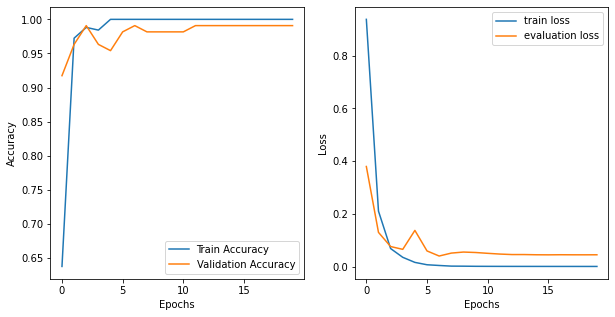

In [ ]:
#@title plot

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');